In [35]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping



In [24]:
# Cargar el archivo Excel
data_path = './Datos históricos TSAT.csv'
data = pd.read_csv(data_path)

# Mostrar las primeras filas y los nombres de las columnas
print(data.head())
print(data.columns)

# Mapa para convertir abreviaturas de meses en español a inglés
meses_es_a_en = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr',
    'may': 'May', 'jun': 'Jun', 'jul': 'Jul', 'ago': 'Aug',
    'sep': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

# Función para convertir formato de fecha 'mes-año' en español a ordinal
def convertir_fecha_ordinal(fecha):
    mes, año = fecha.split('-')
    mes_en = meses_es_a_en[mes]  # Convertir mes de español a inglés
    fecha_en = f"{mes_en}-{año}"  # Reformato a inglés
    fecha_dt = datetime.strptime(fecha_en, '%b-%y')  # Convertir a objeto datetime
    fecha_ordinal = fecha_dt.toordinal()  # Convertir a número ordinal
    return fecha_ordinal


data['Fecha_ordinal'] = data['Fecha'].apply(convertir_fecha_ordinal)

# Crear columna Target para clasificación
data['Target'] = (data['Cierre'].shift(-1) > data['Cierre']).astype(int)
data.dropna(inplace=True)  # Elimina filas donde cualquier columna tenga NaN


# Mostrar las primeras filas para verificar la conversión
print(data.head())

    Fecha  Cierre
0  ago-06   25.70
1  sep-06   26.32
2  oct-06   29.04
3  nov-06   30.73
4  dic-06   40.72
Index(['Fecha', 'Cierre'], dtype='object')
    Fecha  Cierre  Fecha_ordinal  Target
0  ago-06   25.70         732524       1
1  sep-06   26.32         732555       1
2  oct-06   29.04         732585       1
3  nov-06   30.73         732616       1
4  dic-06   40.72         732646       1


In [26]:
# División de datos
X = data['Fecha_ordinal_scaled'].values  # Convertir a numpy array
y = data['Target'].values  # Convertir a numpy array si aún no lo has hecho

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape de los datos para cumplir con los requisitos de entrada de LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, 1))


In [39]:


# Construcción del modelo
model = Sequential([
    LSTM(50, input_shape=(1, 1), return_sequences=True),
    LSTM(50),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Configurar el EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Entrenamiento del modelo con EarlyStopping
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


Epoch 1/200


C:\Users\yourk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.4827 - loss: 0.6932 - val_accuracy: 0.6364 - val_loss: 0.6923
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4885 - loss: 0.6932 - val_accuracy: 0.6364 - val_loss: 0.6919
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4868 - loss: 0.6933 - val_accuracy: 0.6364 - val_loss: 0.6922
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5039 - loss: 0.6931 - val_accuracy: 0.6364 - val_loss: 0.6921
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4930 - loss: 0.6932 - val_accuracy: 0.6364 - val_loss: 0.6922
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5245 - loss: 0.6930 - val_accuracy: 0.6364 - val_loss: 0.6925
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5439 - loss: 0.6930 - val_accuracy: 0.6591 - val_loss: 0.6928
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4627 - loss: 0.6931 - val_accuracy: 0.3636 - val_loss: 0.6937
Epoch 9/200

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Umbral de 0.5 para clasificación binaria
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
[[26  2]
 [14  2]]
              precision    recall  f1-score   support

           0       0.65      0.93      0.76        28
           1       0.50      0.12      0.20        16

    accuracy                           0.64        44
   macro avg       0.57      0.53      0.48        44
weighted avg       0.60      0.64      0.56        44



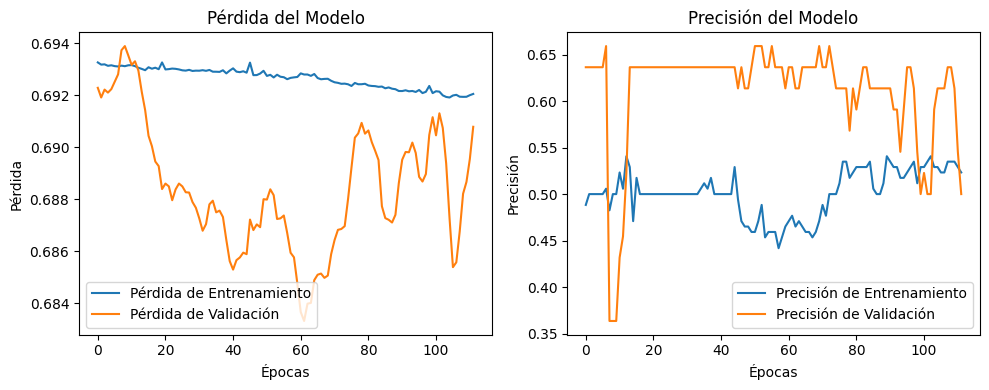

In [41]:
import matplotlib.pyplot as plt

# Graficar la pérdida
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()
